<a target="_blank" href="https://drive.google.com/drive/folders/16pelTEYHJ_WwV7I5b9tPgzC3rMVXFDMy?usp=sharing">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

This notebook follows the study of [Managing Risk Smile](https://www.researchgate.net/publication/235622441_Managing_Smile_Risk) to show the advantages and drawbacks of SABR model approach and compute a comparison with Monte-Carlo simulations for European options pricing. This model is compared with SABR Model pricing using Black-Scholes European options pricing.

# Imports

In [11]:
import datetime as dt
from typing import List

import math
import matplotlib.pyplot as plt
import numpy as np
import random
from scipy.stats import norm

In [12]:
import utility_scripts.reference_data as reference_data
from utility_scripts.Pricers.BlackEuropeanOptionsPricer import BlackEuropeanPricing
from utility_scripts.Pricers.MonteCarloSimulation import European_Call_Payoff, European_Put_Payoff, \
GeometricBrownianMotion
from utility_scripts.Implied_Volatility.SABRImpliedVolatilities import SABR_ATMVol, SABR_ImpliedVol

# Part I : Study of volatility smile

The first part of this notebook gives an illustration on how SABR parameters can affect the volatility smile phenomenon. The model is given by :

$$d\hat{F} = \hat{\alpha}\hat{F}^{\beta} dW_1 \text{,} \quad \hat{F}(0) = f \\
d\hat{\alpha} = \nu\hat{\alpha} dW_2 \text{,} \quad \hat{\alpha}(0) = \alpha$$

We call $t_{ex}$ the exercise date. The parameters of the models are :

$\alpha$ : The initial volatility term for the diffusion of the stochastic volatility process $\hat{\alpha}$

$\beta$ : The backbone term

$\rho$ : The correlation factor between the two brownian motions $dW_1$ and $dW_2$ such as $dW_1dW_2 = \rho dt$

$\nu$ : The volatility of volatility, "volvol" term

We also define $\sigma_{ATM}$ the At-The-Money implied volatility. This approach is based on approximated formula for implicit volatility given in the article, at (3.1a) and (3.1b).

$$
\begin{aligned}
\sigma_B(K, f) = \frac{\alpha} {f^{1-\beta}}\{1-\frac{1}{2}(1-\beta-\rho \lambda) \log{\frac{K}{f}} + \frac{1}{12}\left[(1-\beta)^2+\left(2-3 \rho^2\right) \lambda^2\right] \log ^2{\frac{K}{f}} + \cdots
\end{aligned}
$$

with $\lambda = \frac{\nu}{\alpha} f^{1-\beta}$ which measures the strength of $\nu$ compared to the local volatility $\frac{\alpha}{f^{1-\beta}} $ at the current forward.

We want to reproduce the phenomenons observed for Figure 3.1 and Figure 3.2 shown below :

<p align="center">
  <img src="./Implied_vol_beta_0.JPG" />
</p>

<p align="center">
  <img src="./Implied_vol_beta_1.JPG" />
</p>

The dashed curve represents the _backbone_, which is the curve of the ATM volatility, which is given by (2.18) :

$$\begin{aligned}
\sigma_{ATM} = \sigma_B(f, f) = \frac{\alpha}{f^{1-\beta}} \Biggl\{1 + \Biggl[ \frac{(1-\beta)^2}{24} \frac{\alpha^2}{f^{2-2\beta}} + \frac{1}{4} \frac{\rho \beta \alpha \nu}{f^{1-\beta}} + \frac{2-3\rho^2}{24}\nu^2 \Bigl]t_{ex} + \cdots
\end{aligned}$$

We will consider the $\cdots$ terms in the development as negligible compared to the first terms.

In [13]:
# Forward prices range
forward_prices: List[float] = np.arange(0.04,0.12,0.01)

In [14]:
# ATM value from reference data
reference_SABR = SABR_ATMVol()
eps: float = .01
assert np.abs(reference_data.atm_vol - reference_SABR.ATM_Implied_Vol()) < eps
print(reference_SABR.ATM_Implied_Vol())

0.20970442708333334


We compute the values for the curves to recover the Figures 3.1 and 3.2

In [23]:
def plot_figs(
    strikes: List[str], f: float = reference_data.forward, alpha: float = reference_data.alpha,
    beta: float = reference_data.beta, rho: float = reference_data.rho, nu: float = reference_data.vol_of_vol,
    t_ex: float = reference_data.maturity):
    implied_vols = [SABR_ImpliedVol(K=strike, f=f, alpha=alpha, beta=beta, rho=rho, nu=nu, t_ex=t_ex)
                    for strike in strikes]
    implied_vols[0].display_ATM(forward_prices=forward_prices) # Same ATM curve for all strikes
    for implied_vol in implied_vols:
        implied_vol.display_ImpliedVol(forward_prices=forward_prices, figure=True)
    plt.legend()
    plt.show()

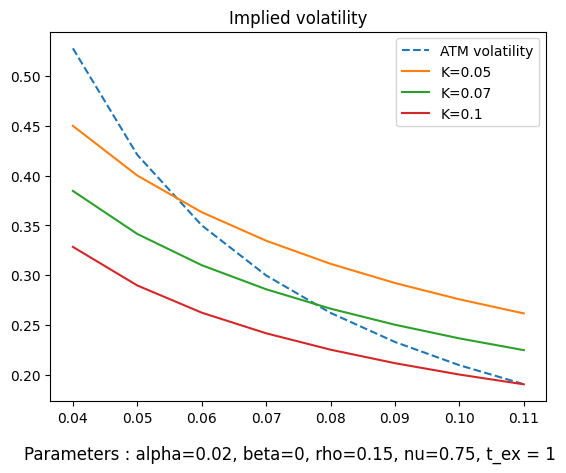

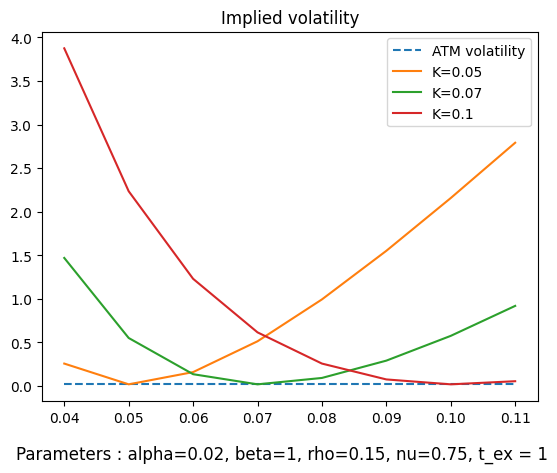

In [24]:
strikes = [0.05, 0.07, 0.1]
plot_figs(strikes=strikes, beta=0)
plot_figs(strikes=strikes, beta=1)

The curves are representative of the results presented in the paper, as for $\beta$ values of 0 and 1 the SABR model represents respectively a stochastic normal model and stochastic log normal model. To study the influence of the parameters, we can look at the specific role of each component of $\sigma_B(K, f)$ formula.

* $\frac{\alpha}{f^{1-\beta}}$ is the implied volatility for at-the-money (ATM) options, so options whose strike $K$ equals the current forward $f$. It is responsible to determine almost entirely the _backbone_. As shown before, $\beta = 0$ gives a steeply downward sloping backbone and $\beta=1$ gives a nearly flat backbone.

* $-\frac{1}{2}(1-\beta-\rho\lambda)\log(\frac{K}{f})$ represents the skew, the slope of the implied volatility with respect to the strike $K$ :
  * $-\frac{1}{2} (1-\beta)\log(\frac{K}{f})$ is the _beta skew_, which is downward sloping as $0 \leq \beta \leq 1$. It arises because the term of "local volatility" $\frac{\hat{\alpha}}{F^{1-\beta}}$ is a decreasing function of the forward price.
  * $-\frac{1}{2}\rho\lambda\log(\frac{K}{f})$ is the _vanna skew_ caused by correlation between the volatility and asset price. This correlation is negative as volatility $\alpha$ decreases as forward $f$ increases.

* The second part of the expression $\frac{1}{12}[(1-\beta)^2 + (2-3\rho^3)\lambda^2] \log^2 \bigl( \frac{K}{f} \bigl)$ can also be decomposed into two parts.
  * $\frac{1}{12}(1-\beta)^2\log^2 \bigl( \frac{K}{f} \bigl)$ is a smile quadratic term but is dominated by the downward sloping beta skew, so it has an influence for reasonable strikes $K$
  * $\frac{1}{12}(2-3\rho^3)\lambda^2\log^2 \bigl( \frac{K}{f} \bigl)$ is the _volga_ (vol-gamma) effect. It represents the rise of the smile when unusual large movements of the forward $\hat{F}$ happen, which is more often when the volatility $\alpha$ increases and less often which it decreases. It causes the strikes $K$ far from the money to be, on average, more representative of high volatility environments.

## Variations of alpha

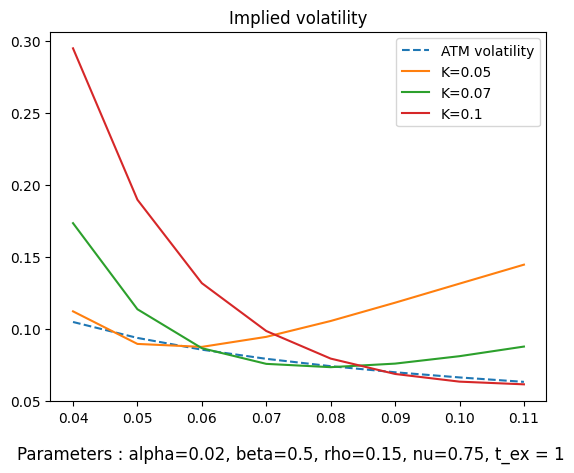

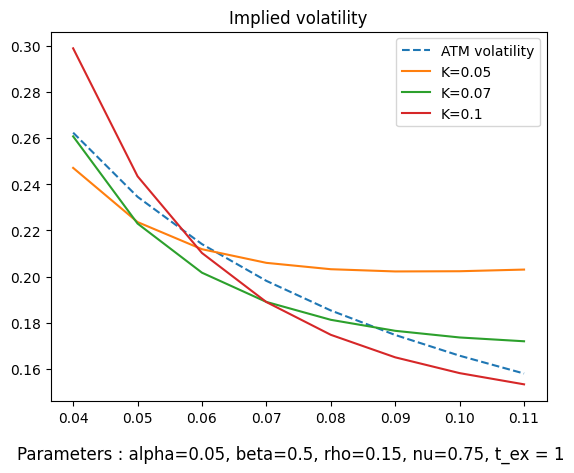

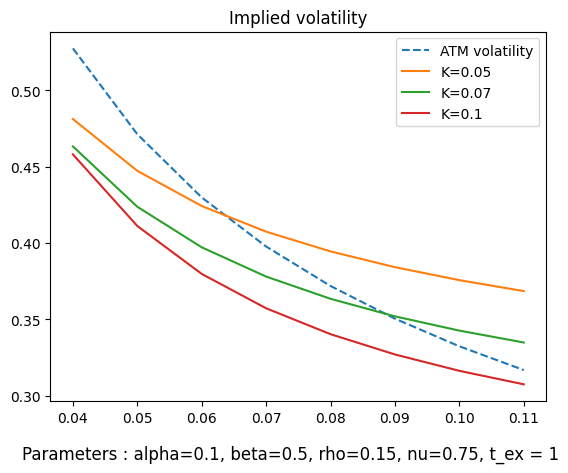

In [30]:
alphas = [0.02, 0.05, 0.1]
for alpha in alphas:
    plot_figs(strikes=strikes, alpha=alpha)

As the volatility $\alpha$ increases, the slope of the _backbone_ becomes steeper, as the quantity $\frac{\alpha}{f^{1-\beta}}$ is responsible for it.

## Variations of beta

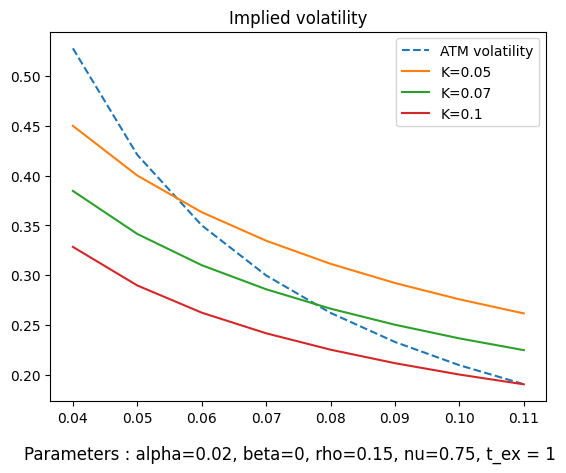

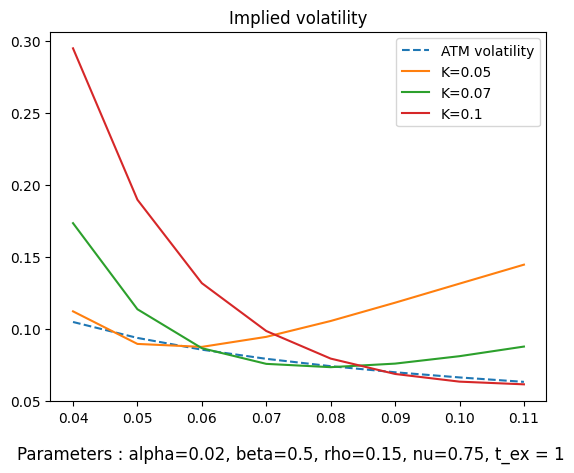

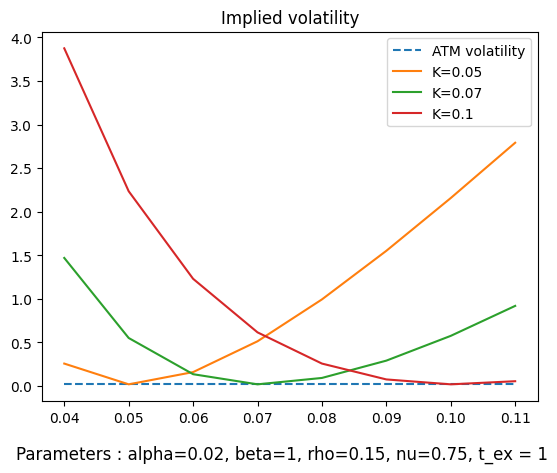

In [31]:
betas = [0, 0.5, 1]
for beta in betas:
    plot_figs(strikes=strikes, beta=beta)

As described earlier, the _beta skew_ phenomenon is observable, especially for backbone slope.

## Variations of volatility of volatility

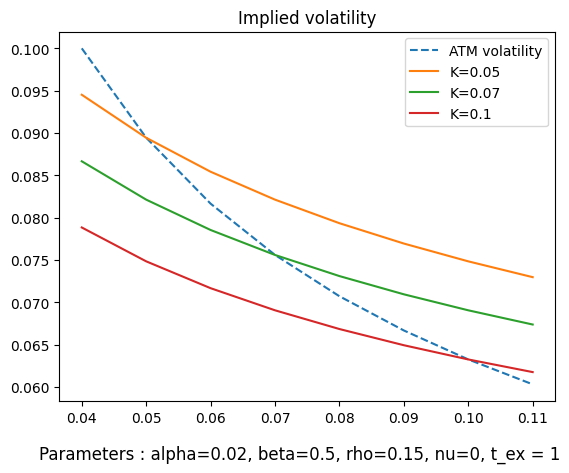

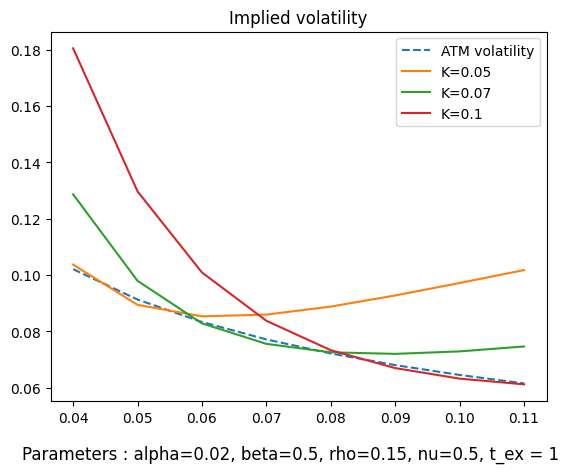

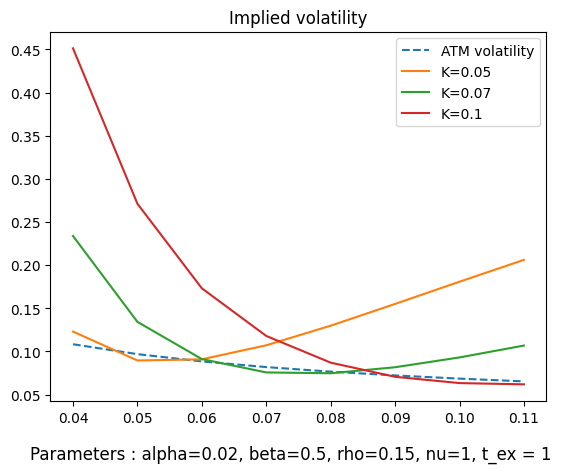

In [26]:
vovols = [0, 0.5, 1]
for vol_of_vol in vovols:
    plot_figs(strikes=strikes, nu=vol_of_vol)

The volatility of volatility parameter increases with $\lambda$ value, so it has an impact on both _vanna skew_ and _volga_ effect. Smile arises with greater values.

## Variations of correlation rho

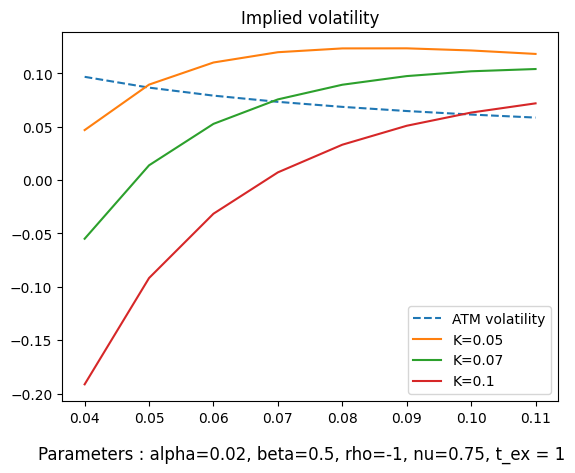

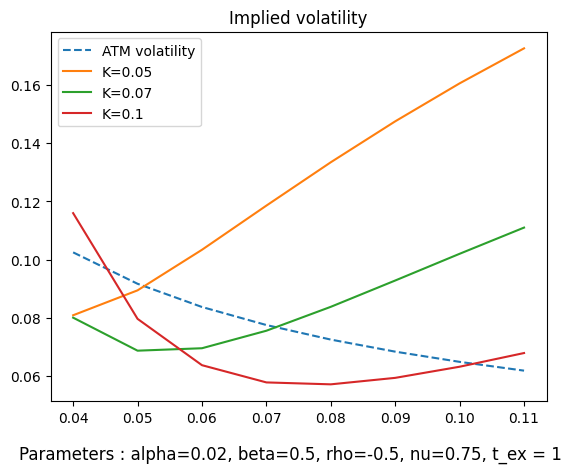

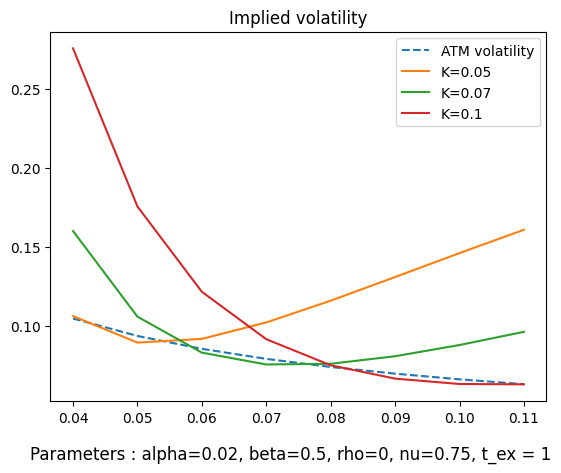

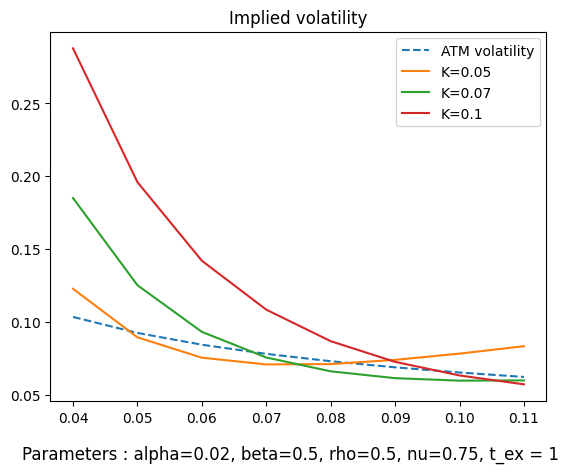

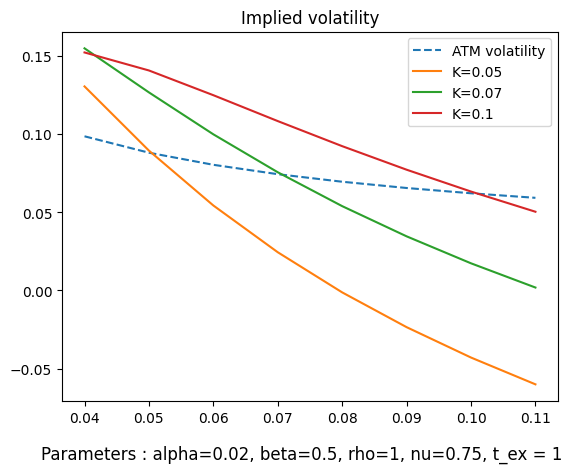

In [28]:
rhos = [-1, -0.5, 0, 0.5, 1]
for rho in rhos:
    plot_figs(strikes=strikes, rho=rho)

As it can be seen on the figures above, the values of correlation $\rho$ between volatility and stock price should be kept as little as possible, as it can have a huge impact on implied volatility derivation and slope of the curve. As the volatility of volatility, it affects both the _vanna skew_ and _volga_ effect.

# Part II : Monte-Carlo simulations for european option pricing

The second part of this notebook is an implementation of a Monte-Carlo pricer for european options and its comparison with Hagan approximation.

This code is inspired from this [article](https://towardsdatascience.com/monte-carlo-pricing-in-python-eafc29e3b6c9). As a first step, we need to simulate the path followed by the stock price $(S_t)_{t \geq 0}$, given by the Black-Scholes dynamics given at equation (2.2c).

We simulate the path by geometric brownian motion. To be able to compare with Hagan approximation formula, we do not consider a drift term in our simulation, so the dynamic of geometric brownian motion is given by equation (2.3) :

$$d\hat{F}(t) = \sigma \hat{F}(t) dW_t \quad \text{with} \quad dW_t \sim \mathcal{N} \bigl( 0, \sqrt{dt} \bigl)$$


with $\sigma$ the volatility being constant, $dt$ is the time step and $dW_t$ a Brownian motion. As we perform a diffusion based on reference data, we use $\sigma = \sigma_{ATM} \approx 21\%$. For simplification purposes, we consider the settlement date at the origin of time and the discount factor such as $D(0)=1$. For each simulated path, the payoff of the call and put options are defined as before. The option price can be calculated by simulating $n$ different paths and averaging the payoffs of all paths. For a detailed description please refer to Hull, *Options, futures, and other derivatives, 8th Edition,* 2012, p. 446 ff.

The following code defines an option pricing formula using Monte Carlo simulation.

In [6]:
def MonteCarloCallPricing(K: float, paths: float = 100, initial_price: float = reference_data.forward, 
                          volatility: float = reference_data.atm_vol, dt: float = 1/365,
                          t_ex: float = reference_data.maturity) -> float:
    price_paths: List[List[float]] = []
    # Generate a set of sample paths
    for i in range(0, paths):
        price_paths.append(GeometricBrownianMotion(initial_price, volatility, dt, t_ex).prices)
    call_payoffs = []
    ec: European_Call_Payoff = European_Call_Payoff(strike=K)
    for price_path in price_paths:
        call_payoffs.append(ec.get_payoff(price_path[-1])) # We get the last stock price in the series generated by GBM to determin the payoff and discount it by one year
    return np.average(call_payoffs)

def MonteCarloPutPricing(K: float, paths: float = 100, initial_price: float = reference_data.forward,
                         volatility: float = reference_data.atm_vol, dt: float = 1/365,
                         t_ex: float = reference_data.maturity) -> float:
    price_paths: List[List[float]] = []
    # Generate a set of sample paths
    for i in range(0, paths):
        price_paths.append(GeometricBrownianMotion(initial_price, volatility, dt, t_ex).prices)
    put_payoffs = []
    ep: European_Put_Payoff = European_Put_Payoff(strike=K)
    for price_path in price_paths:
        put_payoffs.append(ep.get_payoff(price_path[-1])) # We get the last stock price in the series generated by GBM to determin the payoff and discount it by one year
    return np.average(put_payoffs)

Let's compare the previous result with the closed-form approximation formula from Hagan in SABR model. It is given respectively by equations (2.16a), (2.16b) and (2.16c) in the original article and is equal to Black's formula :

$$V_{call} = D(t_{set})(f\mathcal{N}(d_1)-K\mathcal{N}(d_2)) \\
V_{put} = V_{call} + D(t_{set})[K-f]$$

with

$$d_{1,2} = \frac{\log{\frac{K}{f}} \pm \frac{1}{2} \sigma^2 t_{ex}}{\sigma \sqrt{t_{ex}}}$$

This time, the implied volatility $\sigma_B$ is therefore derived from SABR model. We preserve the same simplification purposes and we consider as before $t_{set} = 0$ and $D(0)=1$.

In [8]:
strikes = [0.02, 0.03, 0.04]

tic = dt.datetime.now()

for strike in strikes :
    print("Strike : {}".format(strike))
    # SABR Pricing
    tic = dt.datetime.now()
    SABR_implied_vol = SABR_ImpliedVol(K=strike).Implied_Vol()
    blackeuropeanpricer = BlackEuropeanPricing(K=strike, implied_volatility=SABR_implied_vol)
    call_price = blackeuropeanpricer.Black_call_price()
    print("Call price: {}".format(call_price))
    put_price = blackeuropeanpricer.Black_put_price()
    print("Put price: {}".format(put_price))
    print("Runtime SABR Pricing:  {}".format(dt.datetime.now() - tic))
    
    # Monte-Carlo Pricing
    tic = dt.datetime.now()
    call_price = MonteCarloCallPricing(K=strike)
    print("Call price: {}".format(call_price))
    put_price = MonteCarloPutPricing(K=strike)
    print("Put price: {}".format(put_price))
    print("Runtime Monte-Carlo Pricing:  {}".format(dt.datetime.now() - tic))
    print("\n")

Strike : 0.02
Call price: 0.00012613036875556028
Put price: 0.01012613036875556
Runtime SABR Pricing:  0:00:00.001758
Call price: 0.09196166812788914
Put price: 0.0768846671530086
Runtime SABR Pricing:  0:00:00.232497


Strike : 0.03
Call price: 0.00041111030448464595
Put price: 0.020411110304484642
Runtime SABR Pricing:  0:00:00.000636
Call price: 0.053379422134783534
Put price: 0.08999776934848017
Runtime SABR Pricing:  0:00:00.241024


Strike : 0.04
Call price: 0.0009429733131873235
Put price: 0.030942973313187322
Runtime SABR Pricing:  0:00:00.000752
Call price: 0.06628956453566444
Put price: 0.10648077739899049
Runtime SABR Pricing:  0:00:00.248830




The SABR model is faster than a Monte-Carlo simulation for European options pricing and is more accurate, specifically for capturing volatility smile movements, so it presents more advantages than the classic Monte-Carlo approach with constant volatility from Black's equation. However, the SABR model presents more parameters to define and to be careful of, which involves a higher cost of managing risk, as it is mentioned in the article. In practice, we also notice to obtain greater payoffs with Monte Carlo pricing rather than SABR Model.

In addition, the article [On a one time-step Monte Carlo simulation approach of the SABR model: Application to European options](https://www.sciencedirect.com/science/article/abs/pii/S0096300316305252) provides introduces a method to use Monte-Carlo simulation in order to compensate the approximations made in Hagan formula, particularly due to the correlation between volatility and stock price 